<a href="https://colab.research.google.com/github/dewank01/Machine-Learning/blob/master/COVID_19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Analysis

This notebook contains some analysis based on data from [Our World in Data](https://ourworldindata.org/coronavirus-source-data). If you want to run this notebook yourself, or make changes, just save it to your Google drive (**File | Save a copy in Drive...**) and then run all cells (**Runtime | Run all**). You can also edit cells and rerun them just like any other [Jupyter notebook](https://jupyter.org/).

I created a companion [YouTube video](https://www.youtube.com/watch?v=273KtnPWZnw) explaining some of the details.

Let me know if you have any questions or concerns.

[Madhu Siddalingaiah](https://www.linkedin.com/in/msiddalingaiah/)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

## Load Data

The data appears to be updated daily. You can re-run all cells to see how the numbers evolve.

In [52]:
total_cases = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/total_cases.csv').fillna(0)
total_deaths = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/total_deaths.csv').fillna(0)
new_cases = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/new_cases.csv').fillna(0)
new_deaths = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/new_deaths.csv').fillna(0)

# There's a spike on one day in China, which is probably a reporting error
# Comment the following two lines to see it.
spike = new_cases['China'].values.argmax()
new_cases.iloc[spike] = new_cases.iloc[spike-1]

total_cases.tail()

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bonaire Sint Eustatius and Saba,Bosnia and Herzegovina,Botswana,Brazil,British Virgin Islands,Brunei,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,...,Sierra Leone,Singapore,Sint Maarten (Dutch part),Slovakia,Slovenia,Somalia,South Africa,South Korea,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Swaziland,Sweden,Switzerland,Syria,Taiwan,Tanzania,Thailand,Timor,Togo,Trinidad and Tobago,Tunisia,Turkey,Turks and Caicos Islands,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
98,2020-04-07,1316986,337.0,377.0,1423.0,526.0,16.0,3.0,15.0,1628.0,833.0,71.0,5844,12297,641.0,33.0,756.0,123.0,60.0,700.0,20814,7.0,26.0,39.0,5.0,194.0,2.0,695.0,6.0,12056.0,3.0,135.0,549.0,364.0,3.0,115.0,658.0,16653,7.0,39.0,...,6.0,1375,25.0,534.0,1021.0,7.0,1686.0,10331,1.0,135032,178.0,12.0,10.0,10.0,7206,21574,19.0,373.0,24.0,2258.0,1.0,58.0,105.0,574.0,30217.0,8.0,52.0,1319.0,2076.0,51608,368196,42.0,415.0,397.0,7.0,159.0,245.0,0.0,39.0,9.0
99,2020-04-08,1391888,367.0,383.0,1468.0,545.0,17.0,3.0,15.0,1715.0,853.0,74.0,5956,12640,717.0,36.0,811.0,164.0,63.0,861.0,22194,7.0,26.0,39.0,5.0,210.0,2.0,781.0,6.0,13717.0,3.0,135.0,577.0,384.0,3.0,117.0,685.0,17883,7.0,45.0,...,6.0,1481,40.0,581.0,1055.0,8.0,1749.0,10384,1.0,140510,185.0,14.0,10.0,10.0,7693,22164,19.0,376.0,24.0,2369.0,1.0,65.0,107.0,596.0,34109.0,8.0,52.0,1462.0,2359.0,55242,398809,45.0,424.0,504.0,7.0,166.0,251.0,0.0,39.0,10.0
100,2020-04-09,1476818,423.0,400.0,1572.0,564.0,19.0,3.0,15.0,1795.0,881.0,77.0,6052,12969,822.0,40.0,823.0,218.0,63.0,1066.0,23403,8.0,26.0,39.0,5.0,264.0,2.0,816.0,7.0,15927.0,3.0,135.0,593.0,414.0,3.0,118.0,730.0,19274,7.0,45.0,...,7.0,1623,40.0,682.0,1091.0,8.0,1845.0,10423,2.0,146690,189.0,14.0,10.0,12.0,8419,22710,19.0,379.0,25.0,2423.0,1.0,70.0,107.0,623.0,38226.0,8.0,53.0,1668.0,2659.0,60733,432132,45.0,456.0,555.0,8.0,167.0,251.0,0.0,39.0,11.0
101,2020-04-10,1563857,484.0,409.0,1666.0,583.0,19.0,3.0,19.0,1894.0,921.0,82.0,6152,13248,926.0,41.0,887.0,330.0,66.0,1486.0,24983,9.0,30.0,48.0,5.0,268.0,2.0,875.0,13.0,17857.0,3.0,135.0,624.0,443.0,3.0,119.0,730.0,20748,7.0,45.0,...,7.0,1909,50.0,701.0,1124.0,12.0,1934.0,10450,2.0,152446,190.0,14.0,10.0,12.0,9141,23495,19.0,380.0,25.0,2473.0,2.0,73.0,109.0,643.0,42282.0,8.0,53.0,1892.0,2990.0,65077,466033,50.0,473.0,582.0,8.0,171.0,255.0,1.0,39.0,11.0
102,2020-04-11,1653204,521.0,416.0,1761.0,601.0,19.0,3.0,21.0,1975.0,937.0,86.0,6238,13560,991.0,42.0,998.0,424.0,67.0,1981.0,26667,10.0,35.0,48.0,5.0,276.0,2.0,901.0,13.0,19638.0,3.0,136.0,635.0,448.0,3.0,120.0,803.0,22133,7.0,45.0,...,8.0,1909,50.0,715.0,1160.0,21.0,2003.0,10450,3.0,157022,197.0,15.0,10.0,12.0,9685,24228,19.0,380.0,32.0,2518.0,2.0,76.0,109.0,671.0,47029.0,9.0,53.0,2203.0,3360.0,70272,501560,50.0,494.0,624.0,8.0,175.0,255.0,1.0,40.0,11.0


## Hardest Hit Region

In [53]:
max_death_index = new_deaths.iloc[-1].values[2:].argmax()+2
region = new_deaths.columns[max_death_index]
deaths = new_deaths[region].values[-1]
date = new_deaths.date.values[-1]
if region[-1] == 's':
  region = 'The ' + region
print('{region} has the largest number of recent deaths, totalling {deaths} on {date}'.format(region=region, deaths=deaths, date=date))

The United States has the largest number of recent deaths, totalling 2087 on 2020-04-11


## Regions of Interest

Adjust the next cell to choose regions of interest.

In [0]:
regions = [ 'Italy', 'India', 'United States']
#regions = ['United States']

## New Cases by Date

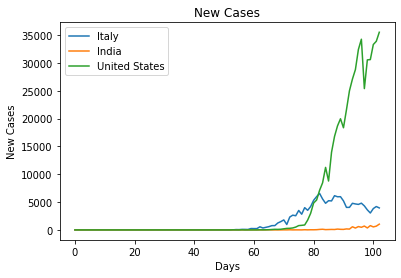

In [55]:
x = new_cases.index
for region in regions:
  plt.plot(x, new_cases[region].values, label=region)
plt.ylabel('New Cases')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.title('New Cases')
plt.show()

## Deaths by Date

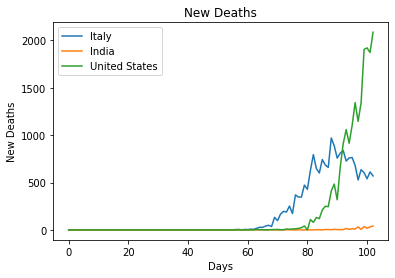

In [56]:
x = new_deaths.index
for region in regions:
  plt.plot(x, new_deaths[region].values, label=region)
plt.ylabel('New Deaths')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.title('New Deaths')
plt.show()

## Doubling Period

Assuming constant exponential growth, the estimate of the number days for COVID-19 to double is

$$r_d = \frac{\Delta t}{log_2(\frac{\Delta n}{n_o})}$$

Where:
* $r_d$ is the doubling period in days
* $\Delta t$ is the average number of days
* $\Delta n$ is the number of new cases in $\Delta t$ days
* $n_o$ is the number of cases $\Delta t$ days ago

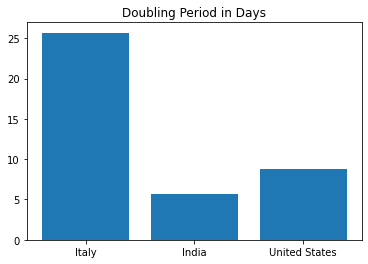

The fastest growing region is India, which is doubling every 5.7 days


In [57]:
dt = 5
regions = ['Italy', 'India', 'United States']
r_d = {}
r_d_list = []
for region in regions:
  n1 = total_cases[region].values[-1]
  n0 = total_cases[region].values[-1-dt]
  dn = (n1-n0)/n0
  r = dt/(np.log2(dn+1))
  r_d_list.append(r)
  r_d[region] = r

y_pos = np.arange(len(regions))

plt.bar(y_pos, r_d_list, align='center')
plt.xticks(y_pos, regions)
plt.title('Doubling Period in Days')
plt.show()

fastest_index = np.array(r_d_list).argmin()
region = regions[fastest_index]
if region[-1] == 's':
  region = 'the ' + region
print('The fastest growing region is {region}, which is doubling every {rate:.1f} days'.format(region=region, rate=r_d_list[fastest_index]))

## Known Infection Projections

Assuming constant exponential growth, the expected number of infections is:

$$n = n_o \times 2^{t/r_d}$$

Where:
* $n$ is the number of actual cases today
* $n_o$ is the number of reported cases today
* $t$ is the number of days
* $r_d$ is the doubling period, in days



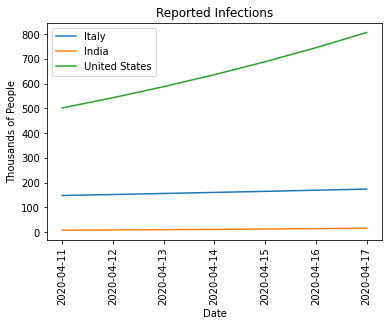

In [58]:
t = np.array(range(7))
start_date = datetime.datetime.strptime(date, '%Y-%m-%d')
date_range = [(start_date+datetime.timedelta(days=int(d))).strftime('%Y-%m-%d') for d in t]

for region in regions:
  n_o = total_cases[region].values[-1]
  n = np.around(n_o * np.exp2(t/r_d[region]))
  plt.plot(t, n/1000, label=region)
plt.ylabel('Thousands of People')
plt.xlabel('Date')
plt.xticks(t, date_range, rotation='vertical')
plt.legend(loc='upper left')
plt.title('Reported Infections')
plt.show()

## Actual Infection Estimates

It is known that many infections are asymptomatic for several days, but still it is still possible transmit the disease. This makes COVID-19 particularly contagious. This suggests the actual number of cases lags reported, tested cases by some number of days. The following is rough projection of real cases using assumptions of doubling rate and symptom/testing lag.

This suggests the number of actual cases today is:

$$n = n_o \times 2^{(t+l)/r_d}$$

Where:
* $n$ is the number of actual cases today
* $n_o$ is the number of reported cases today
* $t$ is the number of days
* $l$ is the reporting lag, in days
* $r_d$ is the doubling period, in days

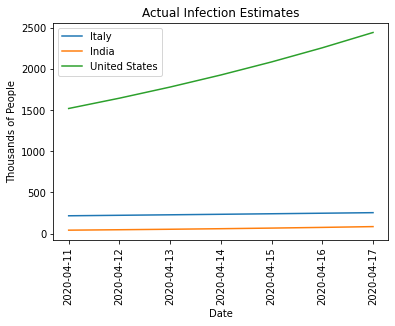

In [59]:
# Estimate of the number of days until symptoms/testing are reported
lag = 14

t = np.array(range(7))
start_date = datetime.datetime.strptime(date, '%Y-%m-%d')
date_range = [(start_date+datetime.timedelta(days=int(d))).strftime('%Y-%m-%d') for d in t]

for region in regions:
  n_o = total_cases[region].values[-1]
  n = np.around(n_o * np.exp2((t+lag)/r_d[region]))
  plt.plot(t, n/1000, label=region)
plt.ylabel('Thousands of People')
plt.xlabel('Date')
plt.xticks(t, date_range, rotation='vertical')
plt.legend(loc='upper left')
plt.title('Actual Infection Estimates')
plt.show()

## Doubling Period over Time

Compute the doubling period for several regions over the last several days. Increasing numbers suggest an reduction in infection rates, which is good.

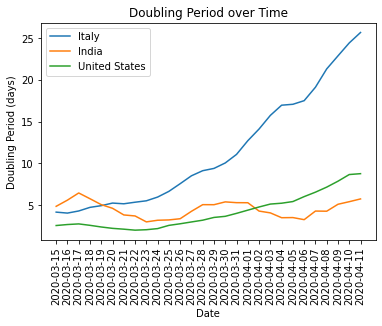

In [60]:
dt = 5
allRegions = total_cases.columns[1:]
r_d_time = {}
for region in regions:
  r_d_time[region] = []

look_back = 28
for region in regions:
  for i in range(-look_back,0):
    n1 = total_cases[region].values[i]
    n0 = total_cases[region].values[i-dt]
    dn = (n1-n0)/n0
    r = dt/(np.log2(dn+1))
    r_d_time[region].append(r)

date_range = range(-look_back,0)
for region in regions:
  #plt.plot(range(-look_back,0), r_d_time[region], label=region)
  plt.plot(date_range, r_d_time[region], label=region)  
#plt.ylim(0, 10)
plt.ylabel('Doubling Period (days)')
plt.xlabel('Date')
plt.xticks(date_range, total_cases.date[-look_back:], rotation='vertical')
plt.legend(loc='upper left')
plt.title('Doubling Period over Time')
plt.show()